# CS109A: Project Milestone 4


## Group #117 (Sukhraj Dulay, Maitri Shah, Paula Zhuang, Josh Zhang)


**Fall 2024**<br/>

Project #17: Analysis of Cambridge Building Energy Use

---

<a id="contents"></a>

## Notebook contents

- [**Finalized Research Question**](#frq)


- [**Data Summary and Basic Insights**](#summary)


- [**GHG Emissions vs. Building Properties**](#vs) 


- [**Baseline Model: Lasso Regression**](#baseline) 


- [**Final Model: Random Forest**](#final) 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


In [26]:
file_path = 'cleaned_data.csv'
data = pd.read_csv(file_path)

print(data.head())



  Reporting ID  Data Year   MapLot Annual Report Received   BEUDO Category  \
0        B1038       2022  106-122                    Yes        Municipal   
1        B1128       2022    35-95                     No  Non-Residential   
2        B1362       2022  265D-58                     No      Residential   
3        B1521       2022    62-34                     No      Residential   
4        B1808       2022    134-2                     No  Non-Residential   

   PD Parcel Living Area  PD Parcel Units                 Address  Year Built  \
0                 153194            205.0        260 Green Street      1973.0   
1                  32775              0.0             155 Gore St         NaN   
2                 309512            294.0  50 CambridgePark Drive      2022.0   
3                 150644            210.0   282-280-278 VASSAR ST      1963.0   
4                  26379              0.0      400 Harvard Street         NaN   

  Buildings Included  ...  Weather Normalize

<a id="frq"></a>

## Finalized Research Question

Based on the available data, from categories present to initial analysis done in Milestone 2, we have the following finalized research question:

How do building characteristics, such as size, age, and primary use type, impact energy use and greenhouse gas emissions in Cambridge, MA?

To study this question, we will first understand the data provided to us (going in detail into the relevant columns and categories) and then determine how best to compare various characteristics of buildings to greenhouse gas emissions. We will search for relationships between both single characteristics and gas emissions, as well as the combination of more than one category and how it affects the emissions of greenhouse gases for such buildings in Cambridge, MA. The ultimate goal of this project is to provide a predictive model for the greenhouse gas emissions of some property in Cambridge, which can provide relevant information on future energy emission for such buildings, areas in which decrease can be attempted, and extrapolations for buildings not exactly identified in this dataset.

<a id="summary"></a>

## Data Summary and Basic Insights

In [27]:
# Output summary statistics for the data
print("Summary Statistics:")
print(f"Dataset Shape: {data.shape}")
print(data.describe())

# List all columns
print("Columns in data:")
print(data.columns.tolist())

# Print number of null cells per column
missing_data = data.isnull().sum()
missing_data = missing_data.sort_values(ascending=False)
print(missing_data)

# Print data types
print("\n\nData Types:")
print(data.dtypes)

Summary Statistics:
Dataset Shape: (851, 46)
       Data Year  PD Parcel Living Area  PD Parcel Units   Year Built  \
count      851.0           8.510000e+02       682.000000   811.000000   
mean      2022.0           4.856433e+05        95.423754  1961.570900   
std          0.0           8.800051e+05       218.424120    46.600994   
min       2022.0           8.625000e+03         0.000000  1718.000000   
25%       2022.0           5.807050e+04         1.000000  1930.000000   
50%       2022.0           1.229840e+05         6.000000  1972.000000   
75%       2022.0           3.489830e+05        83.000000  1999.000000   
max       2022.0           3.691096e+06      1027.000000  2022.000000   

       Buildings Included Count  Property GFA - Self Reported (ft2)  \
count                851.000000                          811.000000   
mean                   1.401880                       112696.113440   
std                    1.669293                       116157.854327   
min          

From this, we can get an overall idea of important columns for our analysis:

Identifiers for buildings: Reporting ID, Annual Report Received, Owner

Building Category / Characteristics: BEUDO Category, PD Parcel Living Area, PD Parcel Units, Year Built, Buildings Included Count, Primary Property Type - Self Selected, All Property Uses, Property GFA - Self Reported (ft2), ENERGY STAR Score (> 50% null values but kept for additional color)

Energy Information: 'Natural Gas Use (therms)', 'Natural Gas Use (kBtu)', 'Site Energy Use (kBtu)', 'Weather Normalized Site Energy Use (kBtu)', 'Site EUI (kBtu/ft2)', 'Weather Normalized Site EUI (kBtu/ft2)', 'Source Energy Use (kBtu)', 'Weather Normalized Source Energy Use (kBtu)', 'Source EUI (kBtu/ft2)', 'Weather Normalized Source EUI (kBtu/ft2)', 'Total GHG Emissions (Metric Tons CO2e)', 'Total GHG Emissions Intensity (kgCO2e/ft2)'

Less Important (either too many null values (> 50% of the rows are null) or reasoning described): Data Year (all are in 2022), MapLot (does not affect property information), Address (same as MapLot), Reported Residential Units, Buildings Included (specific buildings is less useful), Owner Line 2, 'Electricity Use - Grid Purchase (kWh)', 'Electricity Use - Grid Purchase (kBtu)', 'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)', 'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)', 'Diesel #2 Use (kBtu)', 'Kerosene Use (kBtu)', 'District Chilled Water Use (kBtu)', 'District Steam Use (kBtu)', 'Electricity Use - Generated From Onsite Renewable Systems (kWh)', 'Water Use (All Water Sources) (kgal)', 'Water Intensity (All Water Sources) (gal/ft2)', Latitude, Longitude, Location (doesn't affect characteristics)

In [28]:
# Create a copy with only the important columns
data_imp = data.drop(columns=['Data Year', 
                              'MapLot',
                              'Address',
                              'Reported Residential Units',
                              'Buildings Included',
                              'Owner Line 2',
                              'Electricity Use - Grid Purchase (kWh)', 
                              'Electricity Use - Grid Purchase (kBtu)', 
                              'Fuel Oil #1 Use (kBtu)', 
                              'Fuel Oil #2 Use (kBtu)', 
                              'Fuel Oil #4 Use (kBtu)', 
                              'Fuel Oil #5 & 6 Use (kBtu)', 
                              'Diesel #2 Use (kBtu)', 
                              'Kerosene Use (kBtu)', 
                              'District Chilled Water Use (kBtu)', 
                              'District Steam Use (kBtu)', 
                              'Electricity Use - Generated From Onsite Renewable Systems (kWh)', 
                              'Water Use (All Water Sources) (kgal)', 
                              'Water Intensity (All Water Sources) (gal/ft2)',
                              'Latitude',
                              'Longitude',
                              'Location'])

display(data_imp.head())

,Reporting ID,Annual Report Received,BEUDO Category,PD Parcel Living Area,PD Parcel Units,Year Built,Buildings Included Count,Primary Property Type - Self Selected,All Property Uses,Property GFA - Self Reported (ft2),...,Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Site EUI (kBtu/ft2),Weather Normalized Site EUI (kBtu/ft2),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),Source EUI (kBtu/ft2),Weather Normalized Source EUI (kBtu/ft2),Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/ft2)
0,B1038,Yes,Municipal,153194,205.0,1973.0,1,Parking,Parking (110883.0),110884.0,...,227437.3,230684.0,2.8,2.9,636824.5,645915.3,7.9,8.0,-0.493343,0.2
1,B1128,No,Non-Residential,32775,0.0,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B1362,No,Residential,309512,294.0,2022.0,1,Multifamily Housing,Multifamily Housing (374238.0),374238.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B1521,No,Residential,150644,210.0,1963.0,1,College/University,College/University (13996.0),13996.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.502021,0.0
4,B1808,No,Non-Residential,26379,0.0,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_32429/1211886436.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette="Set2", order=order)


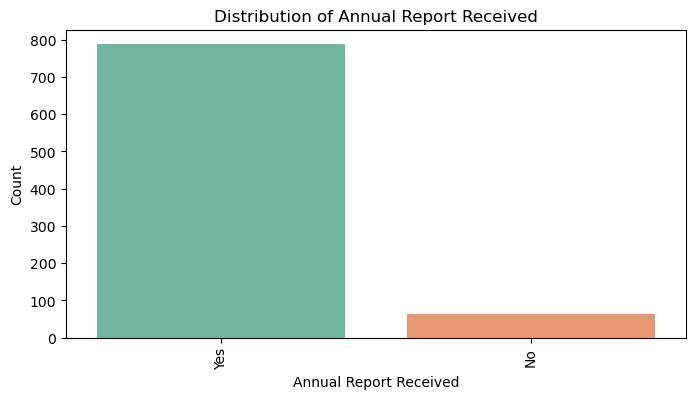

/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_32429/1211886436.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette="Set2", order=order)


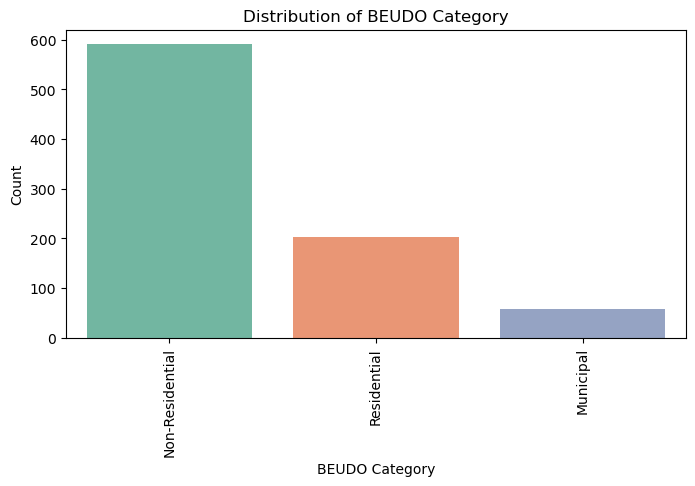

/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_32429/1211886436.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette="Set2", order=order)


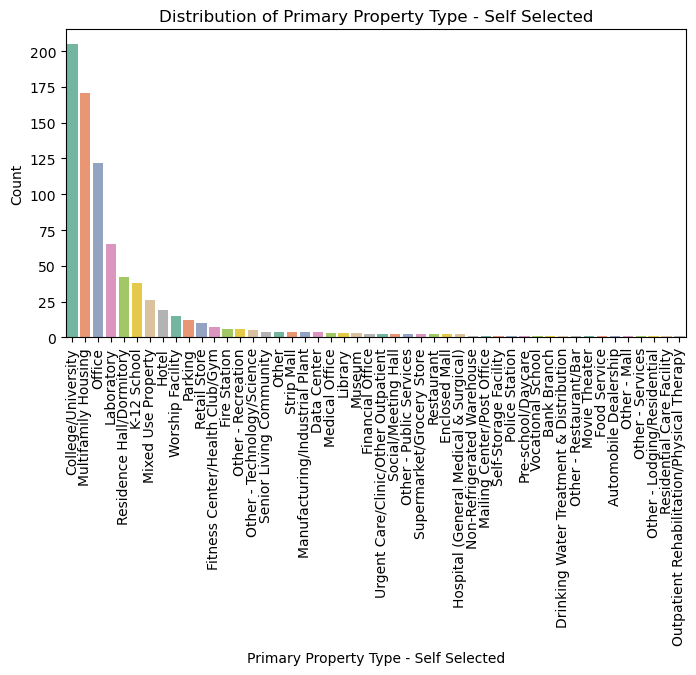

In [29]:
# For categorical variables, plot bar charts to see category distributions

categorical_columns = ['Annual Report Received', 'BEUDO Category', 'Primary Property Type - Self Selected']

for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    order = data[col].value_counts().index
    sns.countplot(data=data, x=col, palette="Set2", order=order)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

The categorical visualizations provide a few key takeaways that are important as we further continue to study the relationships between building category / characteristics and energy consumption.

From the second figure, it is clear that most of the buildings are non-residential (there are 3 times as many non-residential buildings as there are residential), and there are very few municipal. In terms of property type, the 3 most common are College/University, Multifamily Housing, and Office. After this, there are relatively low numbers of each of the other properties, with most of them being close to 1-2.

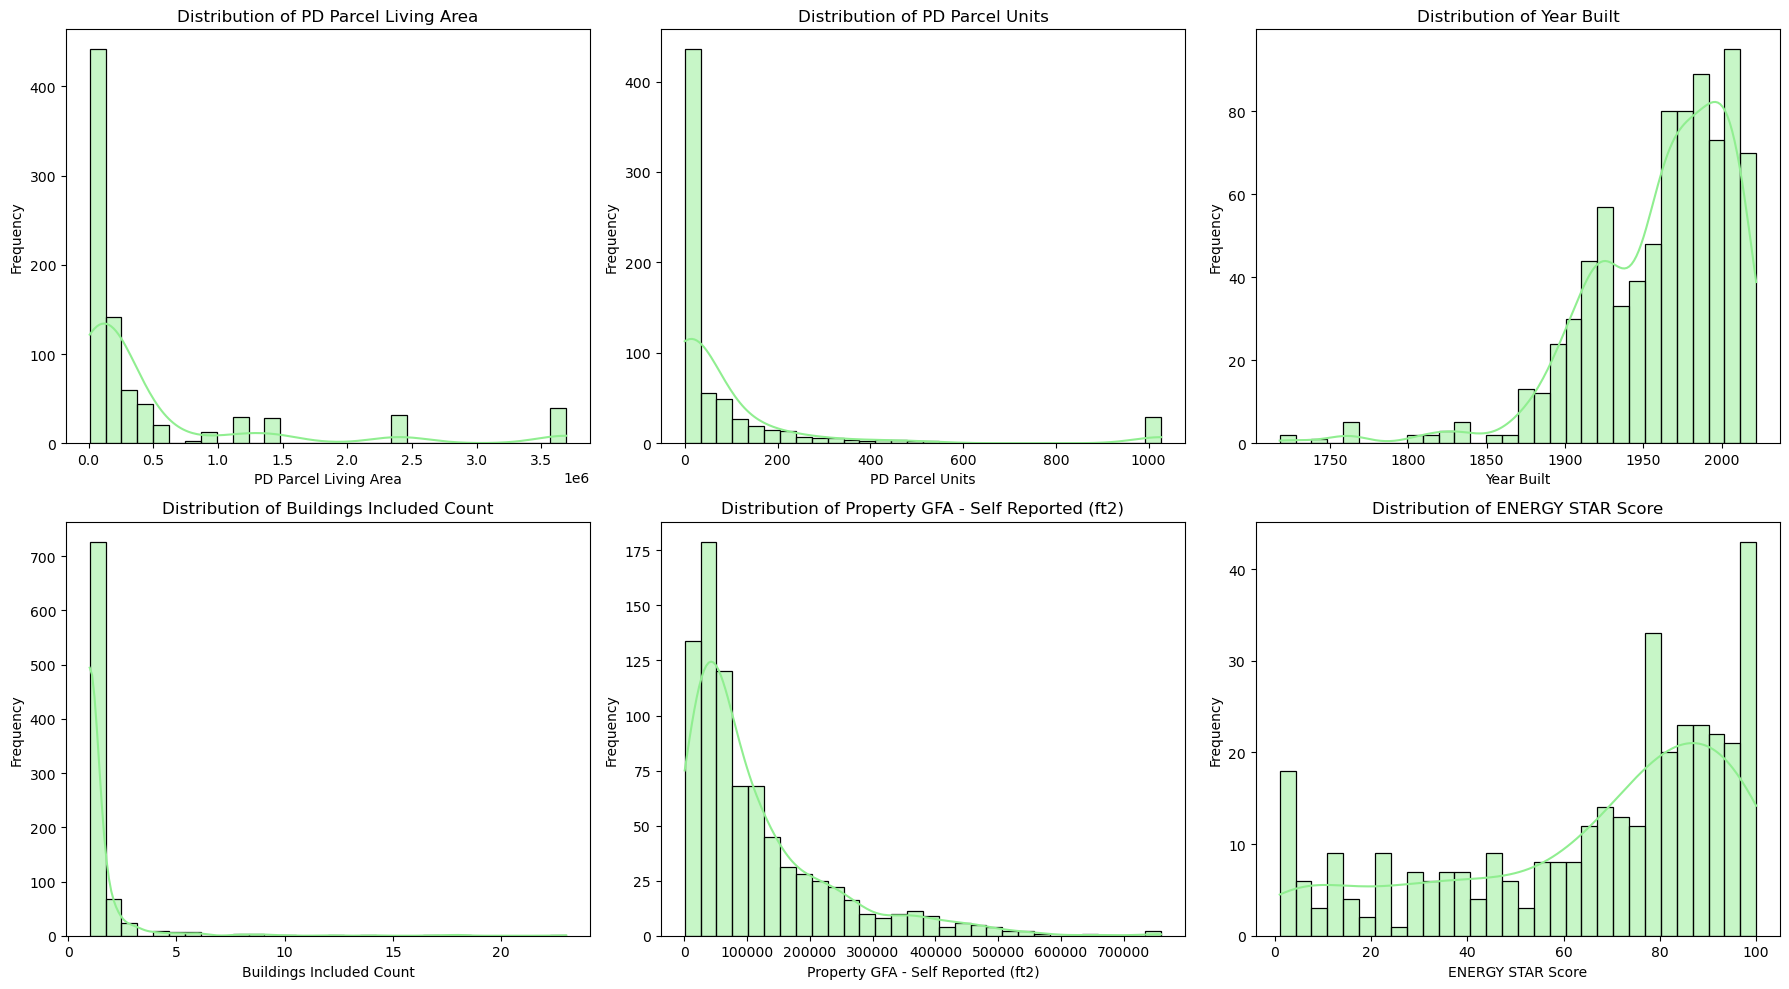

In [30]:
# Understand distribution of data for key characteristics
characteristic_columns = ['PD Parcel Living Area', 'PD Parcel Units', 'Year Built', 
                          'Buildings Included Count', 'Property GFA - Self Reported (ft2)', 'ENERGY STAR Score']

fig, axes = plt.subplots(2, 3, figsize=(18, 10), tight_layout=True) 
axes = axes.flatten()

for i, col in enumerate(characteristic_columns):
    sns.histplot(data[col], bins=30, kde=True, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

These histograms provide a general sense of relative size, year built, and other characteristics of the buildings, but there is a very clear skew for all except for ENERGY STAR Score. It would make more sense to compare these to the property types to see if specific categories of buildings (combination of type with some of these characteristics) can be generated.

We can compare Property GFA, Year Built, and ENERGY STAR Score with the Primary Property Types to see distribution across each property type. These three numerical variables are selected because we have the most distribution in data for them, as seen in the above histograms (the others are very concentrated at one or two values.

/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_32429/2145245393.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Primary Property Type - Self Selected', y=col, palette="Set2")


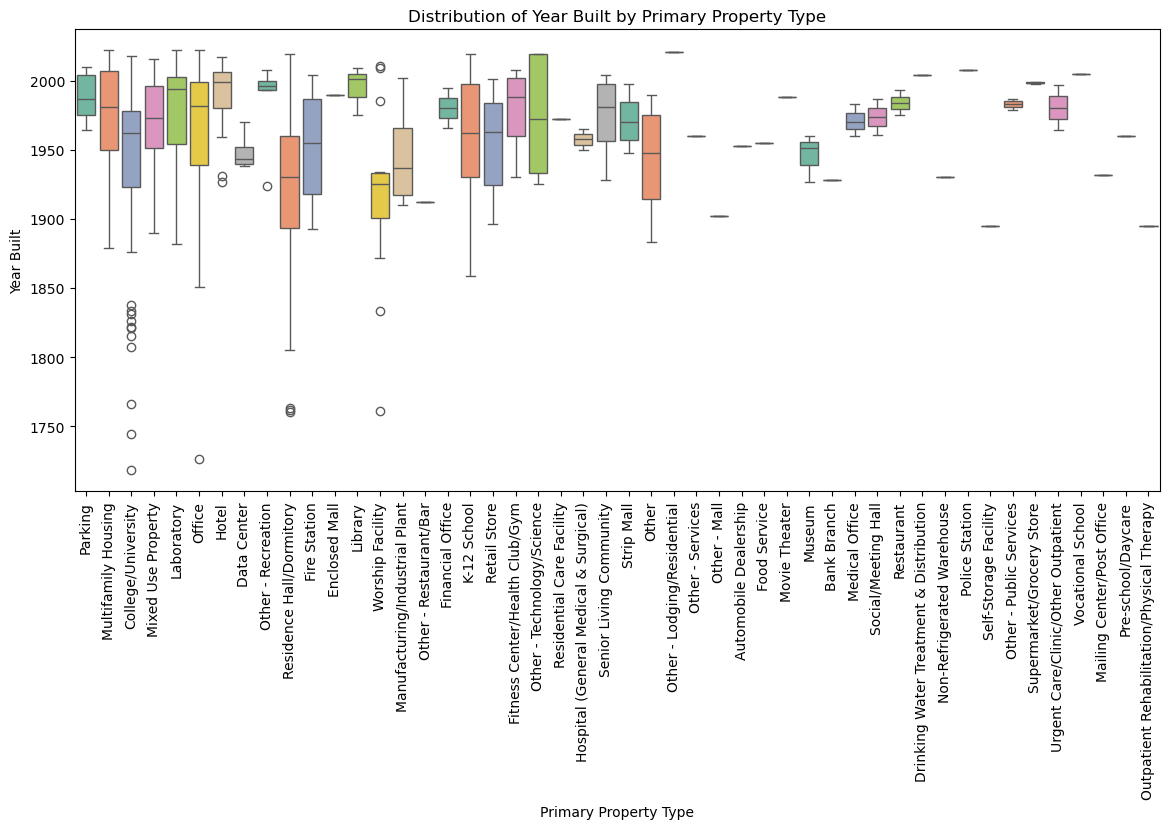

/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_32429/2145245393.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Primary Property Type - Self Selected', y=col, palette="Set2")


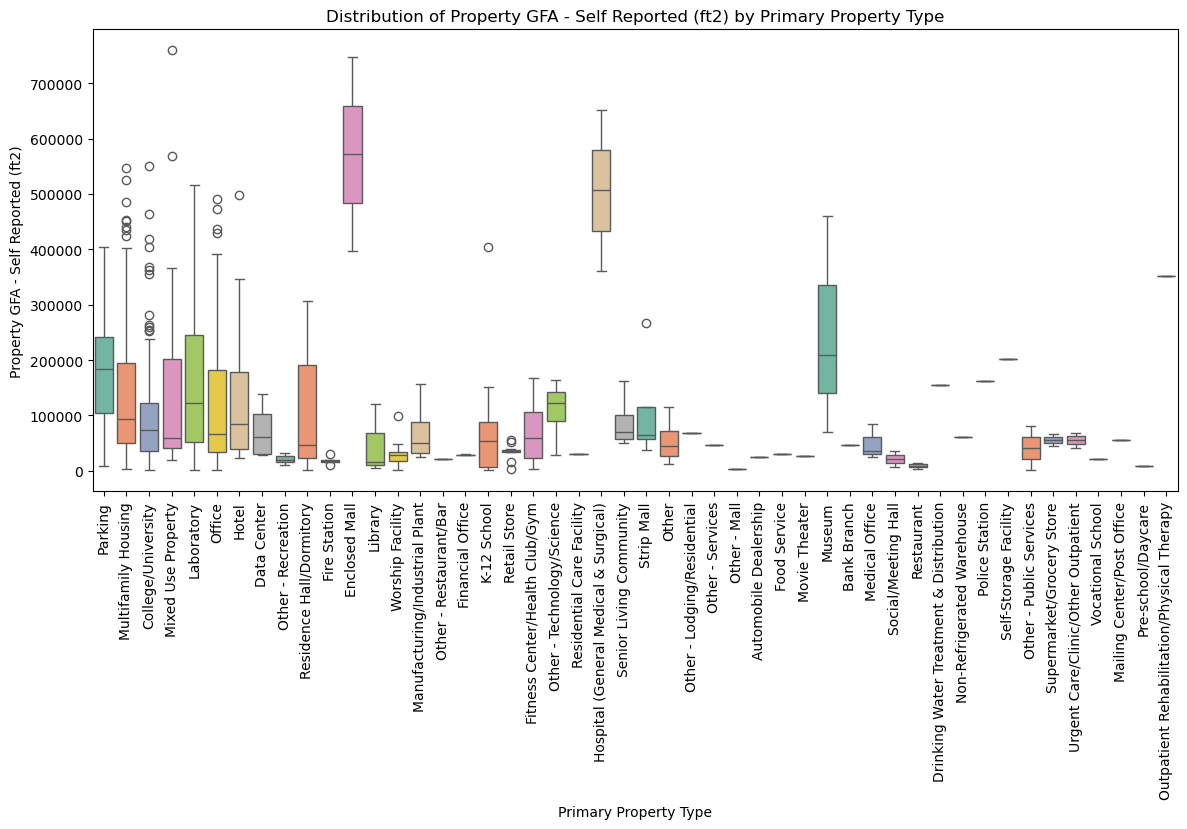

/var/folders/t3/bc1_n5fd0nzg2twmbb9l4m4c0000gn/T/ipykernel_32429/2145245393.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Primary Property Type - Self Selected', y=col, palette="Set2")


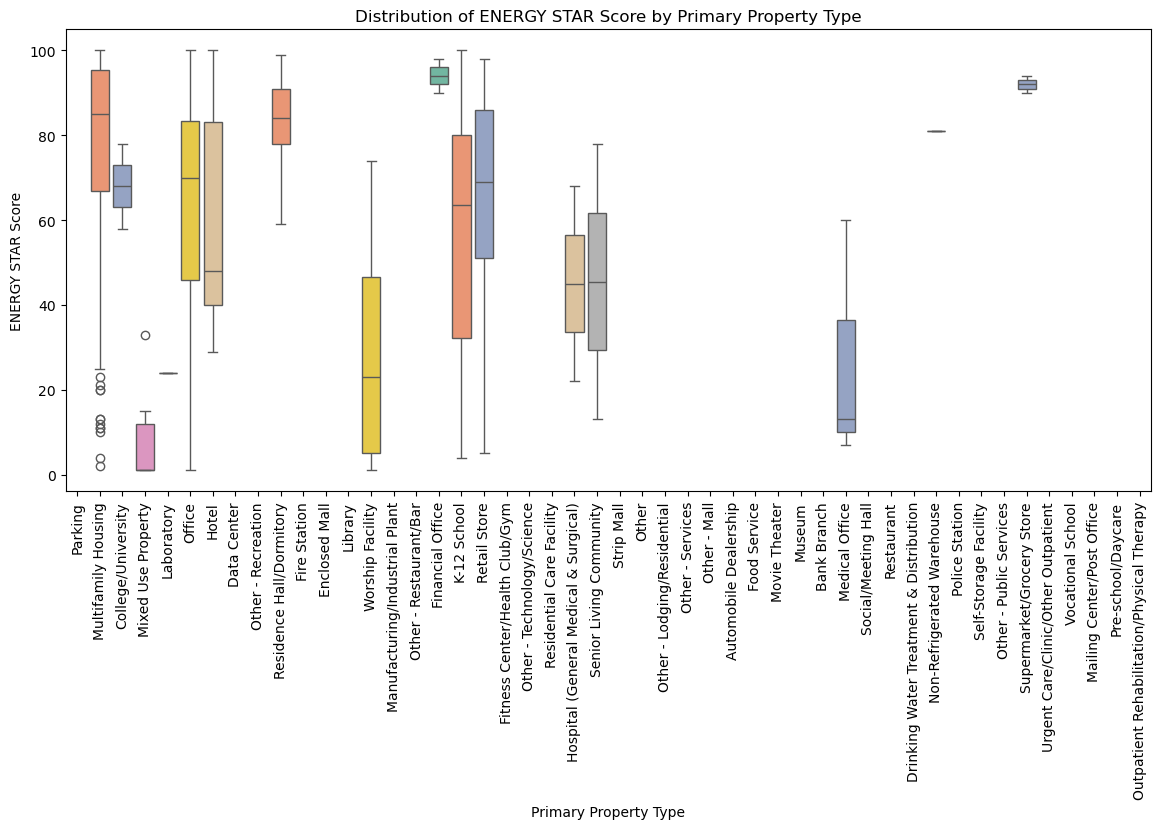

In [31]:
characteristics = ['Year Built', 'Property GFA - Self Reported (ft2)', 'ENERGY STAR Score']

# Loop through each column and create a box plot
for col in characteristics:
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=data, x='Primary Property Type - Self Selected', y=col, palette="Set2")
    plt.title(f'Distribution of {col} by Primary Property Type')
    plt.xlabel('Primary Property Type')
    plt.ylabel(col)
    plt.xticks(rotation=90)
    plt.show()

From this, we come to a few general conclusions about the buildings themselves. While this does not inform much about the correlation with energy usage, consistent and logical findings here support the validity of the data and buildings surveyed.

1. Year Built
Buildings vary widely in construction year, with some categories showing more recent build trends (hotel, recreation facilities, etc.) while others have much older construction years (religious worship facility, college/university, etc.). A lot of these makes sense, because we see a lot of renovation and new buildings in the office and family home space but less in religious facilities or college campuses, which are often preserved over a period of time. 

2. Propery GFA - Self Reported (ft2)
For this metric, there is significant variation across categories, with some properties (college/university and enclosed mall) having much larger overall areas than others (bank branch, medical office). This makes a lot of sense given the type of property and fits with general assumptions around these buildings, which supports the accuracy of the data. It is also important to note that there is a wide range of overall areas in some categories, especially multifamily housing; this suggests a mix of both large and small buildings that make up this category, which is something to consider when we consider the energy consumption of this group in particular. It is also important to note, however, that it is likely that some categories just don't have enough data to - for instance, grocery store / supermarket is shown to have a very small overall area, which logically does not seem correct when compared to buildings like medical offices and libraries.

3. ENERGY STAR Score
The ENERGY STAR Score also varies significantly between property types, but seemingly without much reasoning. Some categories, like residence hall / dormitory and financial office, have fairly high scores; on the other hand, buildings like mixed use property and medical offices have pretty low energy scores. It is difficult to determine the validity of these since we do not have an intuitive idea of what energy scores should be for different property types. It is also likely that ENERGY STAR scores vary across property types due to differences in building use, regulations, or retrofitting practices. In such cases, types with consistent scores may reflect standardized energy practices within those categories.

### Correlation Between Variables

We find the correlation between different variables.

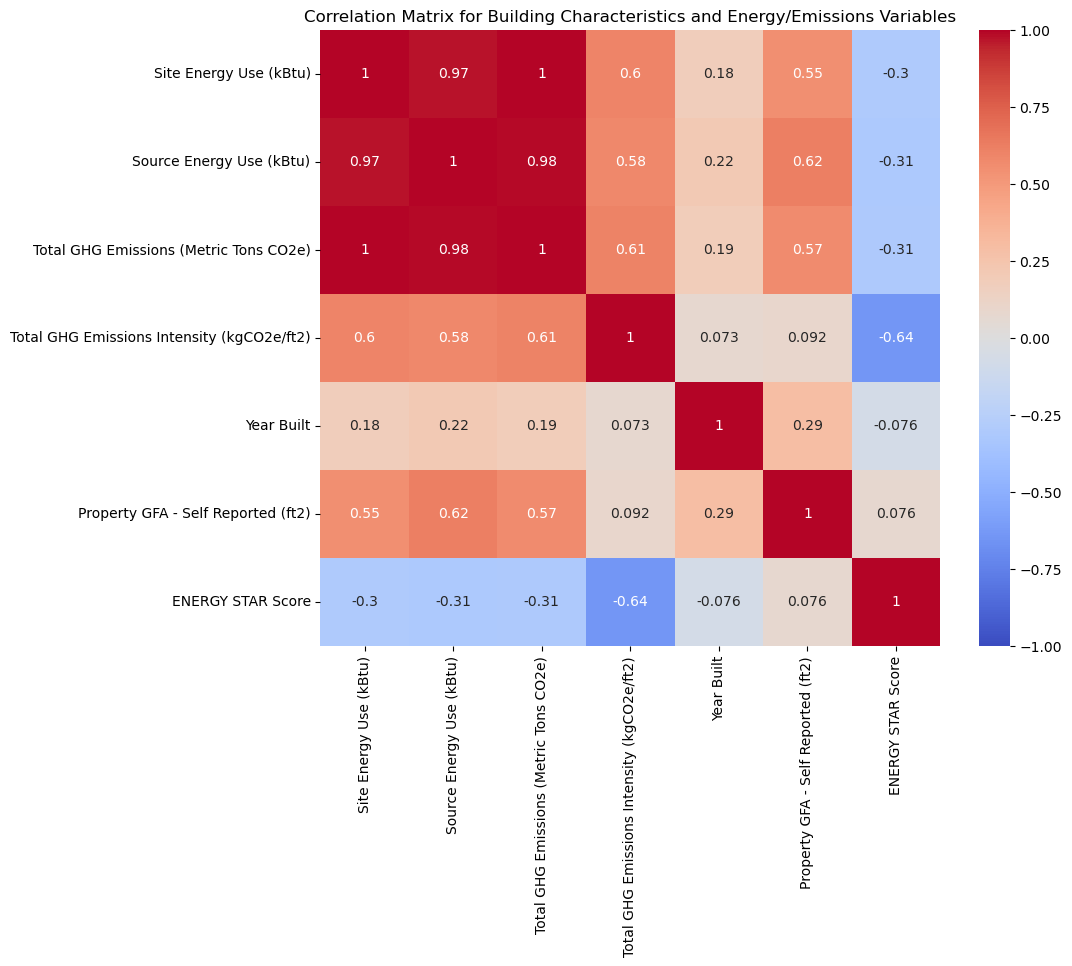

In [32]:
# Calculate and plot correlations with energy use and emissions
energy_columns = ['Site Energy Use (kBtu)', 'Source Energy Use (kBtu)', 'Total GHG Emissions (Metric Tons CO2e)', 'Total GHG Emissions Intensity (kgCO2e/ft2)']
characteristic_columns = ['Year Built', 'Property GFA - Self Reported (ft2)', 'ENERGY STAR Score']

corr_data = data[energy_columns + characteristic_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix for Building Characteristics and Energy/Emissions Variables")
plt.show()

After analyzing this heat map, we find a multitude of correlations between variables:
1. First, we see that the Site Energy Use (kBtu), Source Energy Use (kBtu), and Total GHG Emissions (Metric Tons CO2e) variables are all highly correlated with each other, with coeficients bordering 1. Additionally, we see that all three variables also have essentially identical correlations when compared to each of the characteristics variables as  well.  Being that this is the case, this potentially indicates that these variables are actually capturing similar aspects of data of energy consumption and emissions and that we may be able to utilize only of these variables to encompass the data for all 3 of these variables. This makes intuitive sense as well.
2. GHG Emissions Intensity is fairly correlated with the previous three variables, but not highly. This implies that GHG Emissions Intensity is calculated in a different way rather than a simple division of Total GHG Emissions.
3. We find that there is a moderately high positive correlation between Property GFA - Self Reported (ft2) and each of the respective energy/emission variables with a correlation of $\approx 0.57$. This suggests that larger buildings tend to utilize more energy and emit more GHG, which falls in lines of the expectation that larger buildings tend to utilize more energy/emissions.
4. The Year Built is found to a weak positive correlation between the energy/emission variables of $\approx 0.20$. Through this limited correlation given, no conclusive inference can be made here. 
5. We find there to be a relatively high negative correlation between ENERGY STAR score and energy/emissions consumption of $\approx 0.3$. 

<a id="vs"></a>

## Exploring the Relationship Between GHG Emissions and Building Characteristics

In this section, we create graphs to explore the relationship between a building's GHG emissions (both total and normalized for area) and its characteristics, including BEUDO category, primary property type, property GFA (gross floor area), and 

In [33]:
print("Negatives in Total GHG Emissions Intensity:", (data_imp['Total GHG Emissions Intensity (kgCO2e/ft2)'] < 0).sum())
print("Negatives in Total GHG Emissions:", (data_imp['Total GHG Emissions (Metric Tons CO2e)'] < 0).sum())

Negatives in Total GHG Emissions Intensity: 0
Negatives in Total GHG Emissions: 580


First, we note that more than half of the buildings have a `Total GHG Emissions` that is negative, which from our research, is because  `Total GHG Emissions` includes renewable energy production and the purchase renewable energy credits. `Total GHG Emissions Intensity` does not include that because it only accounts for the greenhouse gasses emitted, without the offsets.

### BEUDO Category

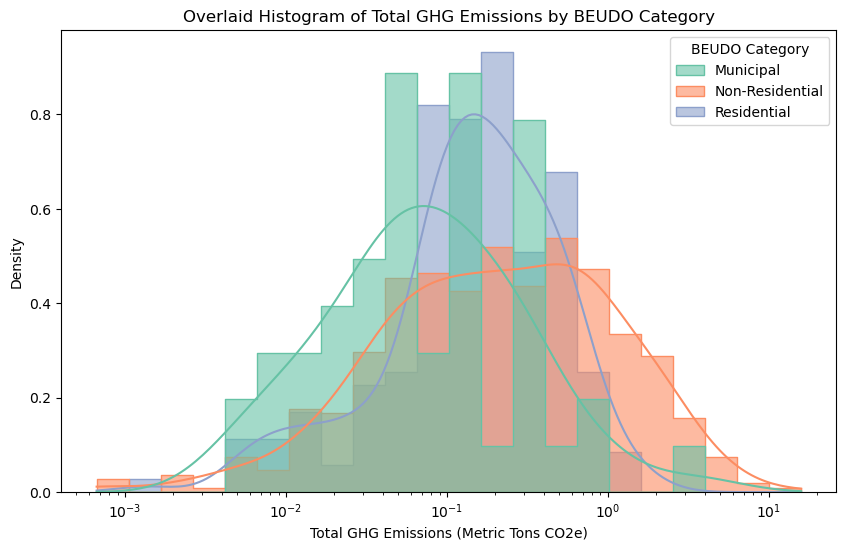

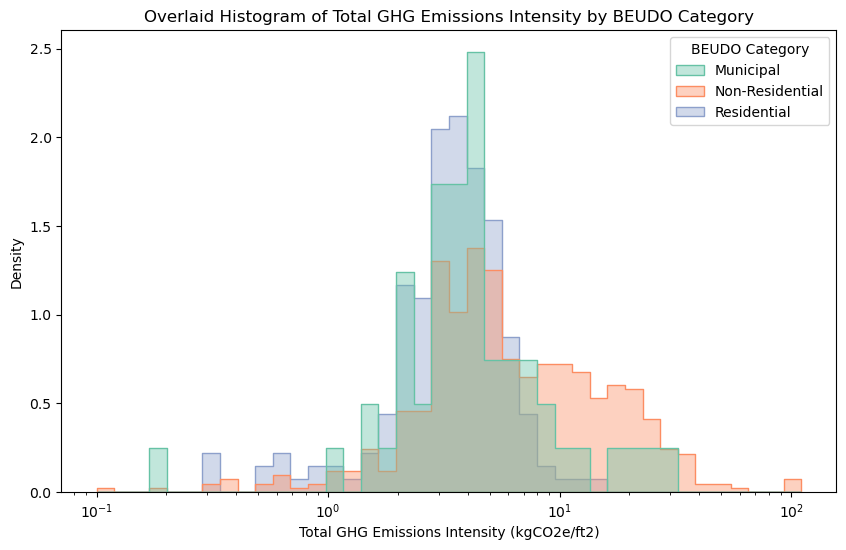

In [34]:
# Shift values to make all emissions positive
shift_amount = data_imp['Total GHG Emissions (Metric Tons CO2e)'].min() + 1
data_imp['Shifted GHG Emissions'] = data_imp['Total GHG Emissions (Metric Tons CO2e)'] + shift_amount

# 1. Plotting a histogram for Total GHG Emissions by BEUDO Category
plt.figure(figsize=(10, 6))
sns.histplot(data=data_imp, x='Shifted GHG Emissions', hue='BEUDO Category', element='step', 
             stat='density', common_norm=False, kde=True, log_scale=True, palette='Set2', alpha=0.6)
plt.title('Overlaid Histogram of Total GHG Emissions by BEUDO Category')
plt.xlabel('Total GHG Emissions (Metric Tons CO2e)')
plt.ylabel('Density')
plt.show()

# 2. Plotting an overlaid histogram for Total GHG Emissions Intensity by BEUDO Category
plt.figure(figsize=(10, 6))
sns.histplot(data=data_imp, x='Total GHG Emissions Intensity (kgCO2e/ft2)', hue='BEUDO Category', element='step', 
             stat='density', common_norm=False, kde=False, log_scale=True, palette='Set2', alpha=0.4, bins=40)
plt.title('Overlaid Histogram of Total GHG Emissions Intensity by BEUDO Category')
plt.xlabel('Total GHG Emissions Intensity (kgCO2e/ft2)')
plt.ylabel('Density')
plt.show()


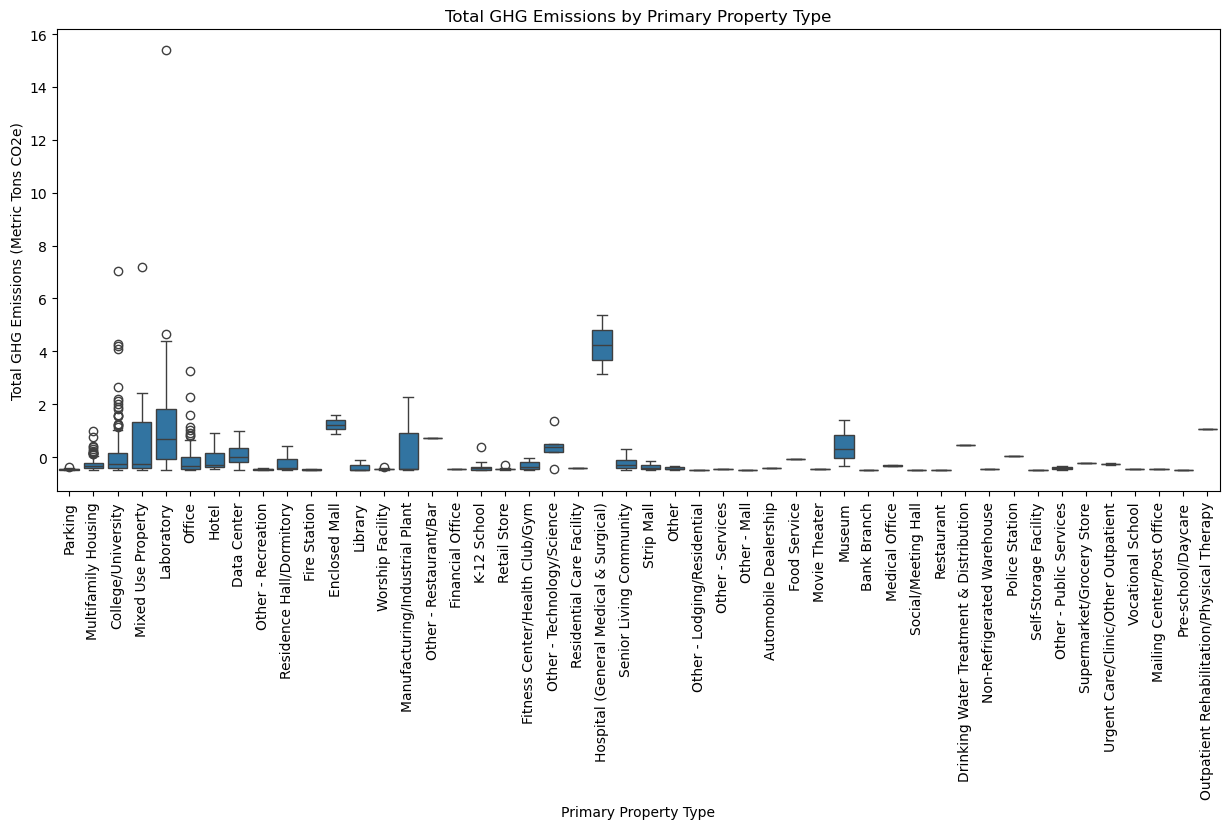

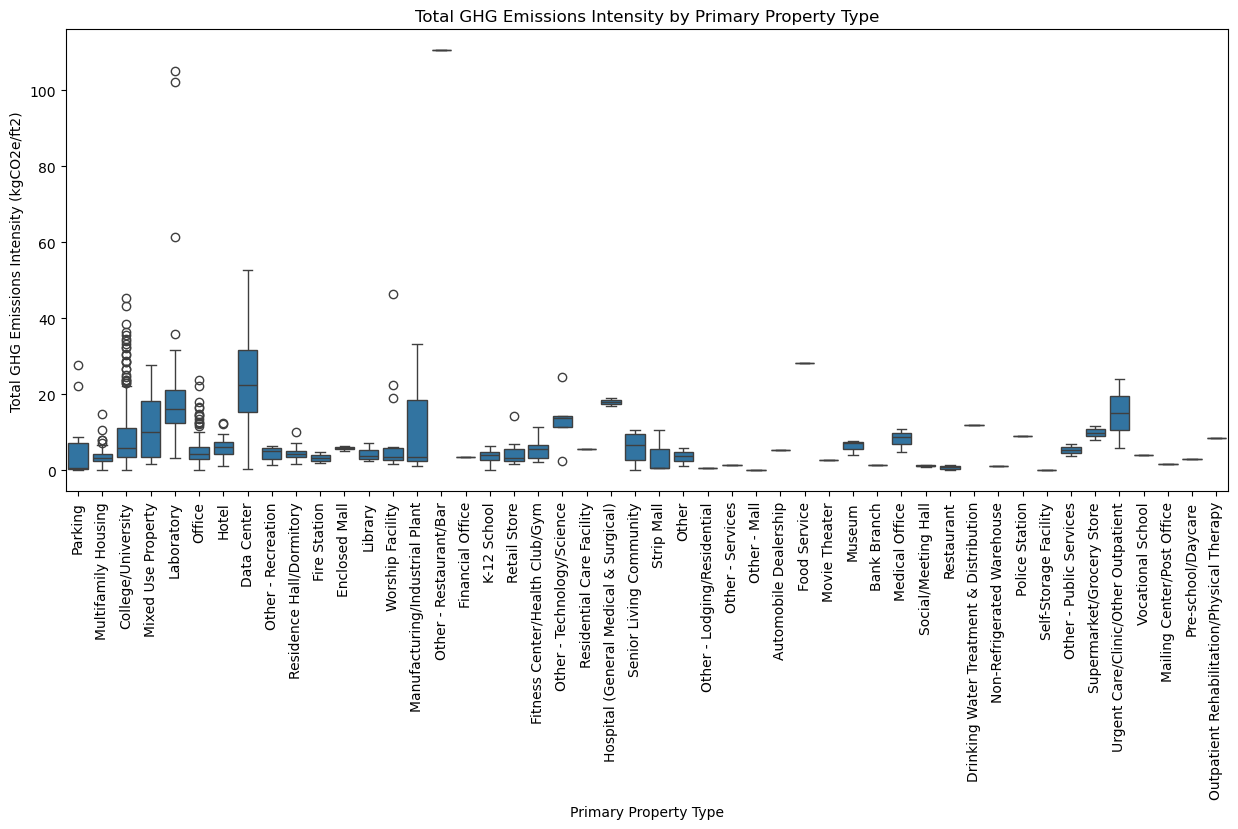

In [35]:
# 3. Boxplot of Total GHG Emissions by Primary Property Type
plt.figure(figsize=(15, 6))
sns.boxplot(data=data_imp, x='Primary Property Type - Self Selected', y='Total GHG Emissions (Metric Tons CO2e)')
plt.title('Total GHG Emissions by Primary Property Type')
plt.xlabel('Primary Property Type')
plt.ylabel('Total GHG Emissions (Metric Tons CO2e)')
plt.xticks(rotation=90)
plt.show()

# 4. Boxplot of Total GHG Emissions Intensity by Primary Property Type
plt.figure(figsize=(15, 6))
sns.boxplot(data=data_imp, x='Primary Property Type - Self Selected', y='Total GHG Emissions Intensity (kgCO2e/ft2)')
plt.title('Total GHG Emissions Intensity by Primary Property Type')
plt.xlabel('Primary Property Type')
plt.ylabel('Total GHG Emissions Intensity (kgCO2e/ft2)')
plt.xticks(rotation=90)
plt.show()

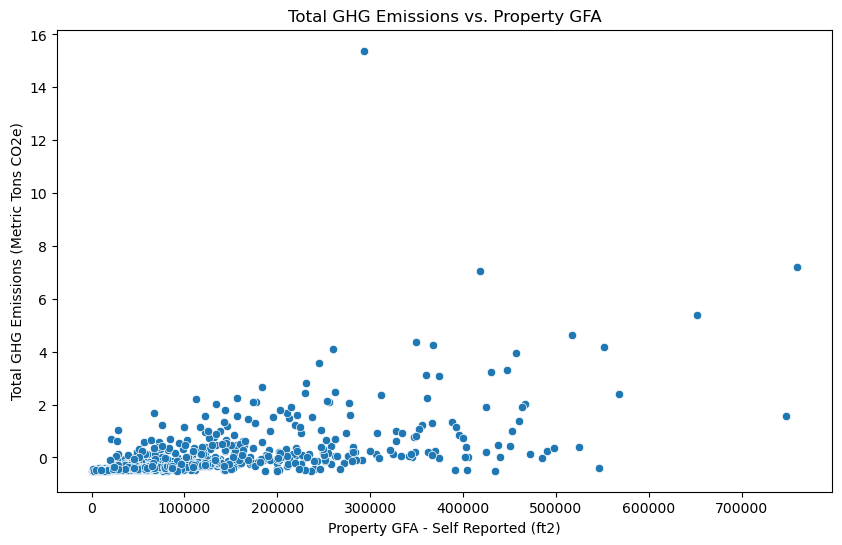

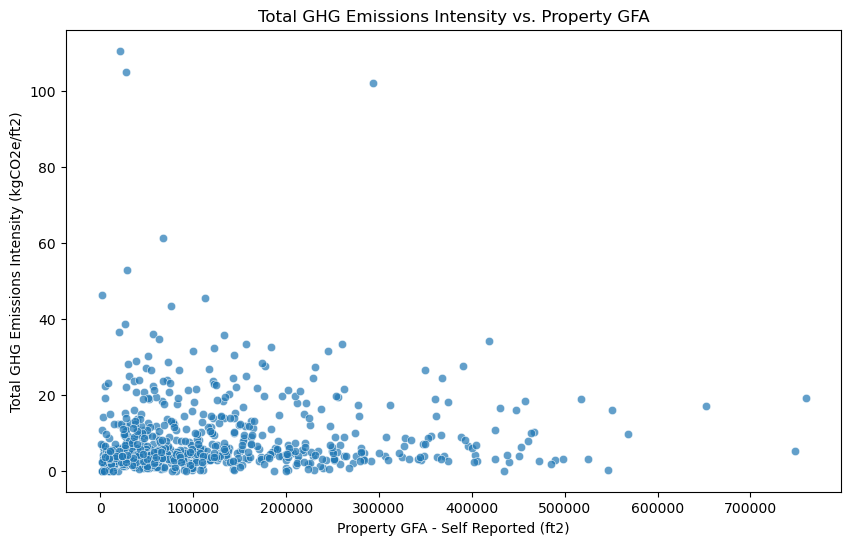

In [36]:
# 5. Scatterplot of Total GHG Emissions vs. Property GFA - Self Reported (ft2)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_imp, x='Property GFA - Self Reported (ft2)', y='Total GHG Emissions (Metric Tons CO2e)')
plt.title('Total GHG Emissions vs. Property GFA')
plt.xlabel('Property GFA - Self Reported (ft2)')
plt.ylabel('Total GHG Emissions (Metric Tons CO2e)')
plt.show()

# 6. Scatterplot of Total GHG Emissions Intensity vs. Property GFA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_imp, x='Property GFA - Self Reported (ft2)', y='Total GHG Emissions Intensity (kgCO2e/ft2)', alpha=0.7)
plt.title('Total GHG Emissions Intensity vs. Property GFA')
plt.xlabel('Property GFA - Self Reported (ft2)')
plt.ylabel('Total GHG Emissions Intensity (kgCO2e/ft2)')
plt.show()

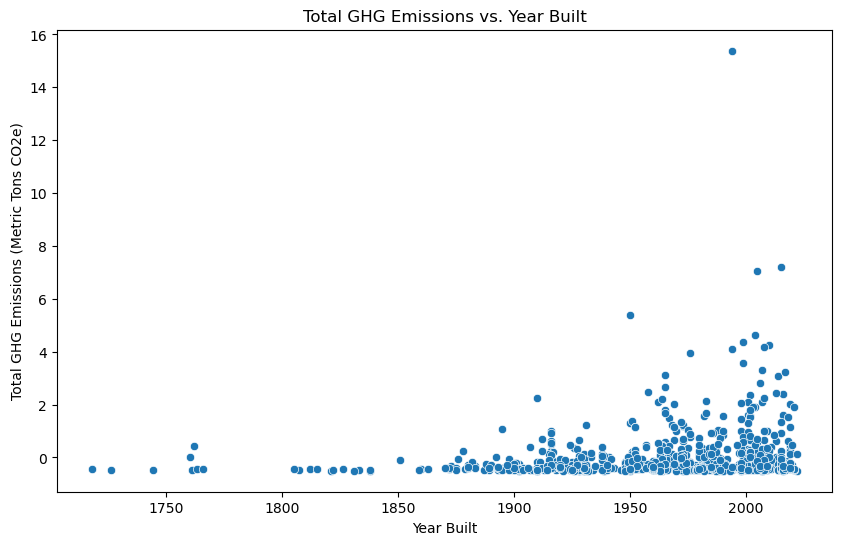

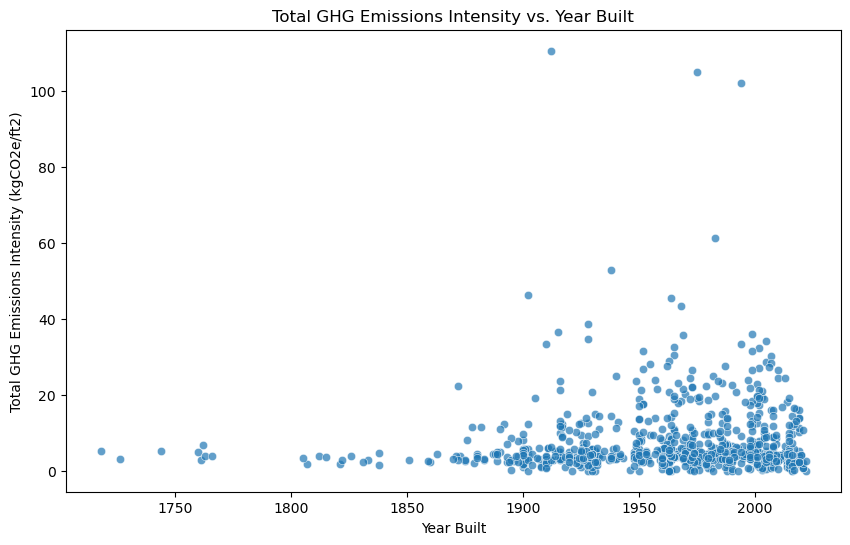

In [37]:
# 7. Scatterplot of Total GHG Emissions vs. Year Built
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_imp, x='Year Built', y='Total GHG Emissions (Metric Tons CO2e)')
plt.title('Total GHG Emissions vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Total GHG Emissions (Metric Tons CO2e)')
plt.show()

# 8. Scatterplot of Total GHG Emissions Intensity vs. Year Built
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_imp, x='Year Built', y='Total GHG Emissions Intensity (kgCO2e/ft2)', alpha=0.7)
plt.title('Total GHG Emissions Intensity vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Total GHG Emissions Intensity (kgCO2e/ft2)')
plt.show()

<a id="baseline"></a>

## Baseline Model: Lasso Regression
We use **Lasso Regression** as our baseline model because:
- It handles multicollinearity by penalizing less important features.
- It provides an interpretable model by shrinking coefficients of less relevant variables to zero.

Both of these are important for our data because we have a large number of factors that could impact overall GHG emissions, so it is important to ensure that the relevant ones are considered to a greater extent. Additionally, given that some of the factors have fewer data points overall, a Lasso regression model prioritizes them less in the final feature determination.

---

### Model Pipeline:
1. Data preprocessing: Scaling and encoding.
2. Model training: Using the Lasso algorithm.
3. Evaluation: Assessing RMSE and R² metrics.


In [38]:
from sklearn.model_selection import train_test_split
# Define the target variable
target = 'Total GHG Emissions (Metric Tons CO2e)'
columns_to_drop = ['Data Year', 'Latitude', 'Longitude', 'Location']
data_cleaned = data.drop(columns=columns_to_drop)

# Handle missing values (impute or drop selectively)
for col in ['Property GFA - Self Reported (ft2)', 'Year Built']:
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mean())
data_cleaned = data_cleaned[data_cleaned[target].notnull()]

# Select features and target variable
features = ['Property GFA - Self Reported (ft2)', 'Year Built', 'BEUDO Category']
target = 'Total GHG Emissions (Metric Tons CO2e)'

X = data_cleaned[features]
y = data_cleaned[target]

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Train Lasso Regression model
baseline_model = Lasso(alpha=0.1)
baseline_model.fit(X_train, y_train)

# Predict on test set
y_pred = baseline_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Baseline Model RMSE: {rmse:.2f}")
print(f"Baseline Model R^2: {r2:.2f}")


Baseline Model RMSE: 0.59
Baseline Model R^2: 0.52


The RMSE and R^2 values provide an understanding of how well our baseline model is performing. The RMSE of 0.59 indicates the average magnitude of prediction errors, and this shows that the predictions are fairly accurate on average. Fine-tuning for the final model will hopefully bring this average up. The R^2 means that 52% of the variation in emissions is explained by features that we included here. Based on this, there is still a fair amount of unexplained variability, so for the final, we will try to include more features (or different groups of features) to try and capture as much of the variability as possible. For now, we will look at the feature importance from this model – changes will be made for the final model (just so that we can compare between the two at the end).

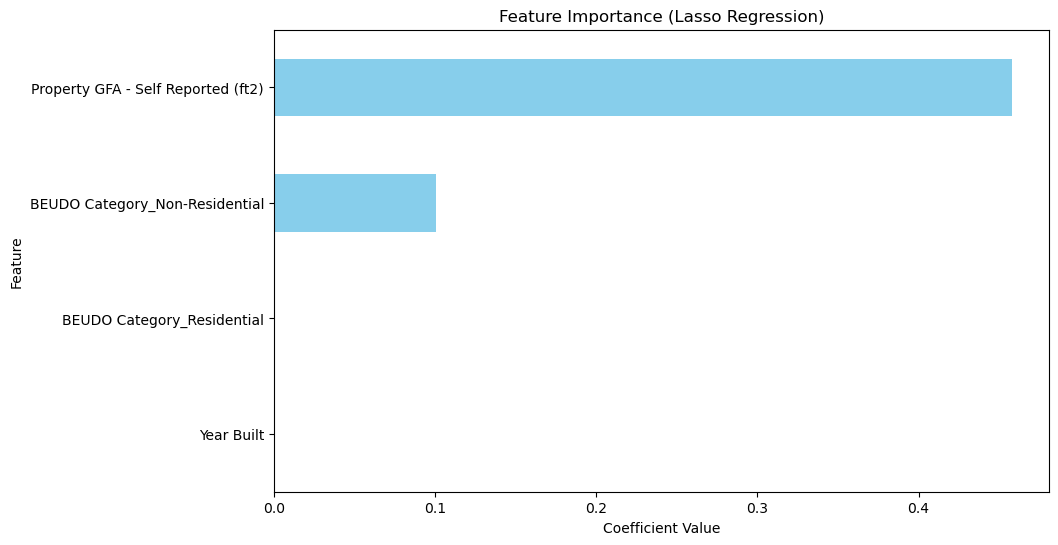

In [39]:
feature_importance = pd.Series(baseline_model.coef_, index=X.columns)
feature_importance = feature_importance.sort_values()

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', color='skyblue')
plt.title("Feature Importance (Lasso Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


From the comparison of these three, it seems that the most significant predictor of greenhouse gas emissions is Property GFA, which has the largest positive coefficient. This means that larger properties are associated with higher emissions, which logically makes sense because they would likely have increased energy demands within the building (in regards to heating, cooling, etc.). The next most prominent indicator is BEUDO Category Non-Residential, which shows that non-residential buildings (officers, commercial spaces, etc.) play a much higher role in contributing to GHG emissions as compared to the residential category. The smaller coefficient for Residential spaces indicates that they have less of an impact on emissions. It also seems that Year Built is not very indicative of GHG emissoins, since the coefficient is near 0.

Next, we want to see the residuals.

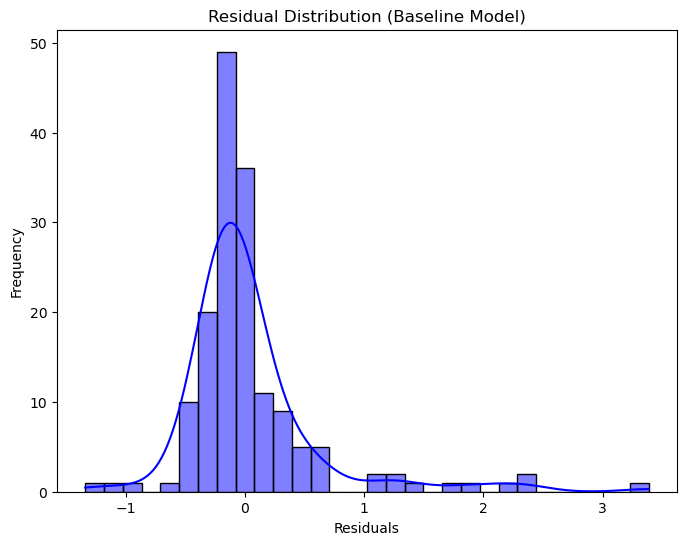

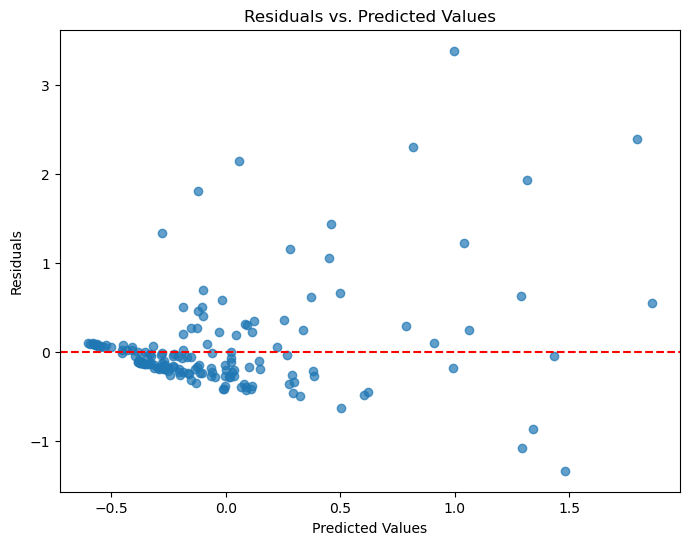

In [40]:
residuals = y_test - y_pred

# Plot residual distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Residual Distribution (Baseline Model)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Plot residuals vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


The distribution of residuals shows that most are centered by 0, which indicates that the baseline model is pretty good at capturing the general trend of the data without bias. With that said, there is a bit of a right-skew tail and some large positive residuals; this means that the model might underpredict for some instances (mostly higher target values). We also see this in the second plot, since residuals are tightly clustered around the 0 line for lower predicted values but a lot more variable for the higher values. Since we are seeing this trend of the model underpredicting larger values, it might mean that we are missing some non-linear relationships or interactions in the data; using stronger or more accurate models might help with this.

In [41]:
scores = cross_val_score(baseline_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-scores)
print(f"Cross-validated RMSE: {rmse_cv.mean():.2f} ± {rmse_cv.std():.2f}")


Cross-validated RMSE: 0.76 ± 0.31


This cross-validated RMSE means that the baseline model is pretty accurate for predictions, but there is a high standard deviation so the model might be unstable across different folds.

**Overall Baseline Model Thoughts**
It seems like the baseline Lasso Regression model is good at getting the central trends in the data, but the residual analysis does show that an area for improvement is at higher prediction values. There is a lot of variability and potential hereoscedasticity there, suggesting that the model might be underpredicting. We would want to adjust a few things for the final model, like incorporating non-linear relationships, using interaction terms, or even trying an alternative model like a tree-based on that can handle non-linear relationships better.

<a id="final"></a>

## Final Model: Random Forest

Finally, we set up a pipeline to improve on our baseline model, ensuring that we can run experiments and obtain the optimal version.

1. Parameter Search: We set up a Grid Search with CV to find the best alpha parameter. The alpha parameter in Lasso controls the trade-off between fitting the training data well (low bias) and keeping the model simple (low variance); optimizing it lets us find the balance between underfitting and overfitting, resulting in a model that generalizes well to unseen data.
2. Feature Selection: Experimenting with adding a feature that was found to be important in our original analysis, 'Primary Property Type - Self Selected'.
3. Feature Engineering: Experimenting with adding interaction terms.

In [42]:
from sklearn.model_selection import GridSearchCV

# Range of alpha values to test
alpha_values = np.logspace(-5, 0, 50)

# Grid search for the best alpha
lasso = Lasso()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_lasso = grid_search.best_estimator_

print(f"Best Alpha: {best_alpha}")

# Predict on test set
y_pred_best_lasso = best_lasso.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_lasso))
r2 = r2_score(y_test, y_pred_best_lasso)

print(f"Improved Lasso Model RMSE: {rmse:.2f}")
print(f"Improved Lasso Model R^2: {r2:.2f}")

Best Alpha: 1e-05
Improved Lasso Model RMSE: 0.57
Improved Lasso Model R^2: 0.56


We found that this model does not improve on our RMSE and R-squared values from the baseline, so we switched to a Random Forest model. Here is the updated pipeline.

1. Feature Selection: Using 'Primary Property Type - Self Selected' as the selected feature, since it was identified as important in prior analysis.
2. Feature Engineering: Adding interaction terms to look at non-linear relationships.
3. Log Transformations: Introducing logarithmic scaling on predictors and response variables to enhance model fit.

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

# Custom Log Transformer with feature name compatibility
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [f"log1p({col})" for col in input_features]
        return [f"log1p(feature_{i})" for i in range(X.shape[1])]

# Define combinations of features and log transformations
feature_combinations = [
    {'interaction_terms': False, 'include_property_type': False},  # Baseline
    {'interaction_terms': True, 'include_property_type': False},  # Interaction terms only
    {'interaction_terms': False, 'include_property_type': True},  # Property type only
    {'interaction_terms': True, 'include_property_type': True},  # Both
]

log_combinations = [
    {'log_X': False, 'log_y': False},  # No log transformation
    {'log_X': True, 'log_y': False},  # Log predictors only
    {'log_X': False, 'log_y': True},  # Log response only
    {'log_X': True, 'log_y': True},  # Log both predictors and response
]

results = []

for combo in feature_combinations:
    for log_combo in log_combinations:
        print(f"Testing combination: {combo}, Log Transform: {log_combo}")

        # Select features and target variable
        features = ['Property GFA - Self Reported (ft2)', 'Year Built', 'BEUDO Category']
        numerical_features = ['Property GFA - Self Reported (ft2)', 'Year Built']
        categorical_features = ['BEUDO Category']

        if combo['include_property_type']:
            categorical_features.append('Primary Property Type - Self Selected')
            features.append('Primary Property Type - Self Selected')

        # Handle missing values
        for col in ['Property GFA - Self Reported (ft2)', 'Year Built']:
            data[col] = data[col].fillna(data[col].mean())
        data = data.dropna(subset=['Total GHG Emissions (Metric Tons CO2e)'])

        target = 'Total GHG Emissions (Metric Tons CO2e)'
        X = data[features]
        y = data[target]

        # Apply log transformation on predictors
        transformers = []
        if log_combo['log_X']:
            transformers.append(('log', LogTransformer(), numerical_features))
        
        transformers.append(('scaler', StandardScaler(), numerical_features))
        transformers.append(('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_features))

        if combo['interaction_terms']:
            transformers.append(('poly', PolynomialFeatures(degree=2, include_bias=False), numerical_features))

        preprocessor = ColumnTransformer(transformers, remainder='drop')

        # Apply log transformation to response variable
        if log_combo['log_y']:
            y = np.log1p(y)  # Log transformation on y

        # Pipeline with RandomForest and OOB validation
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('random_forest', RandomForestRegressor(
                n_estimators=200,
                oob_score=True,
                max_features='sqrt',
                random_state=42
            ))
        ])

        # Fit pipeline
        pipeline.fit(X, y)

        # Retrieve OOB score (R²)
        rf_model = pipeline.named_steps['random_forest']
        oob_r2 = rf_model.oob_score_

        # Predictions on the entire dataset
        y_pred = pipeline.predict(X)
        if log_combo['log_y']:
            y = np.expm1(y)  # Inverse log transform
            y_pred = np.expm1(y_pred)  # Reverse log transform predictions

        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)

        print(f"Log Transform: {log_combo}, OOB R²: {oob_r2:.4f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

        # Feature Importances
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        feature_importances = pd.Series(rf_model.feature_importances_, index=feature_names)
        print("Top Features by Importance:")
        print(feature_importances.sort_values(ascending=False).head(10))

        # Record results
        results.append({
            'Combination': combo,
            'Log_X': log_combo['log_X'],
            'Log_Y': log_combo['log_y'],
            'OOB R²': oob_r2,
            'RMSE': rmse,
            'R²': r2
        })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv('random_forest_oob_log_results.csv', index=False)
print("\nResults saved to 'random_forest_oob_log_results.csv'")


Testing combination: {'interaction_terms': False, 'include_property_type': False}, Log Transform: {'log_X': False, 'log_y': False}
Log Transform: {'log_X': False, 'log_y': False}, OOB R²: 0.3365, RMSE: 0.29, R²: 0.92
Top Features by Importance:
scaler__Property GFA - Self Reported (ft2)    0.672552
scaler__Year Built                            0.256553
onehot__BEUDO Category_Non-Residential        0.046891
onehot__BEUDO Category_Residential            0.024005
dtype: float64
Testing combination: {'interaction_terms': False, 'include_property_type': False}, Log Transform: {'log_X': True, 'log_y': False}
Log Transform: {'log_X': True, 'log_y': False}, OOB R²: 0.3191, RMSE: 0.29, R²: 0.91
Top Features by Importance:
log__log1p(Property GFA - Self Reported (ft2))    0.360309
scaler__Property GFA - Self Reported (ft2)        0.320625
log__log1p(Year Built)                            0.130724
scaler__Year Built                                0.120821
onehot__BEUDO Category_Non-Residential   

In [44]:
results_df

,Combination,Log_X,Log_Y,OOB R²,RMSE,R²
0,"{'interaction_terms': False, 'include_property...",False,False,0.336479,0.288817,0.916585
1,"{'interaction_terms': False, 'include_property...",True,False,0.319108,0.292481,0.914455
2,"{'interaction_terms': False, 'include_property...",False,True,0.538797,0.389478,0.848307
3,"{'interaction_terms': False, 'include_property...",True,True,0.537251,0.399868,0.840105
4,"{'interaction_terms': True, 'include_property_...",False,False,0.291523,0.298552,0.910867
5,"{'interaction_terms': True, 'include_property_...",True,False,0.302004,0.296164,0.912287
6,"{'interaction_terms': True, 'include_property_...",False,True,0.517462,0.413327,0.829161
7,"{'interaction_terms': True, 'include_property_...",True,True,0.523299,0.404038,0.836753
8,"{'interaction_terms': False, 'include_property...",False,False,0.444093,0.259707,0.932552
9,"{'interaction_terms': False, 'include_property...",True,False,0.453243,0.258032,0.933419


### Interpretation
